In [1]:
import numpy as np
import pandas as pd
import json

from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer


from sklearn.metrics.cluster import adjusted_rand_score

import matplotlib.pyplot as plt
from itertools import combinations

### 还原轨迹数据所需函数

In [2]:
def tr_fun(x,params):
    '''
    x: scalar,x-coordinate
    params: ndarray,weights
    module style: a0+a1*x+a2*x^2...
    '''
    x = np.array([x**i for i in range(len(params))])
    ret = np.dot(x,params)
    return ret

### 全局聚类所需函数

In [3]:
def df2array(df):
    # 将数据以 ndarray 的形式读入内存
    # [[x1,x2,...,x500,y1,y2,...,y500],[],...]
    i = 0
    data = np.array([])
    while i <= len(df)-1:
        arr_x = np.array(df['x'][i:i+500])
        arr_y = np.array(df['y'][i:i+500])
        arr = np.append(arr_x,arr_y)
        if len(data)==0:
            data = np.array([arr])
        else:
            data = np.append(data,[arr],axis=0)
        i+=500
    return data

In [4]:
# 确保定义的距离是有效的，非负性，同一性，对称性，直递性（三角不等式）

def dist(tr1,tr2):
    length = len(tr1)
    if not(length == 1000):
        # 传入参数形式为(k,1000)
        # 计算k个簇心点更新前后的距离
        distance = 0
        for i in range(length):
            pre = tr1[i]
            now = tr2[i]
            half = int(len(pre)/2)
            x1 = pre[0:half]
            y1 = pre[half:]
            x2 = now[0:half]
            y2 = now[half:]
            deta_x = x1 - x2
            deta_y = y1 - y2
            distance = distance + np.sum((deta_x**2 + deta_y**2) ** 0.5) / len(x1)
    else:       
        half = int(length/2)
        x1 = tr1[0:half]
        y1 = tr1[half:]
        x2 = tr2[0:half]
        y2 = tr2[half:]
        deta_x = x1 - x2
        deta_y = y1 - y2
        distance = np.sum((deta_x**2 + deta_y**2) ** 0.5) / len(x1)
        # print(distance)
    return distance

In [5]:
def cluster(data,K):

    metric = distance_metric(type_metric.USER_DEFINED, func=dist)
    initial_centers = kmeans_plusplus_initializer(data, K).initialize()

    kmeans_instance = kmeans(data, initial_centers, metric=metric)

    kmeans_instance.process()
    clusters = kmeans_instance.get_clusters()
    centers = kmeans_instance.get_centers()
    
    return clusters,centers

In [6]:
# ndarray中每个元素长度要相等
def getKmeansResult(data,K):
    clusters,centers = cluster(data,K)
    labels = np.zeros(len(data))
    for i in range(K):
        for j in range(len(data)):
            if j in clusters[i]:
                labels[j] = i
    return labels,np.array(centers)

In [7]:
def cost(data,labels,centers):
    loss = 0
    for i in range(len(data)):
        loss = loss + dist(data[i],centers[int(labels[i])])
    loss = loss / len(data)
    return loss # 平均每个簇的损失

In [8]:
def chooseK(data,K):
    x = np.arange(3,K+1)
    y = np.zeros(len(x))
    for k in range(3,K+1):
        labels,centers = getKmeansResult(data,k)
        y[k-3] = cost(data, labels,centers)
    plt.plot(x,y)
    plt.xlabel('K')
    plt.ylabel('cost')
    plt.grid(True)
    plt.show()

### main

In [9]:
# resample 50 points each segment
def resample(tr_id,x_minmax,params):
    segment_num = len(params)
    global RESAMPLE_DATA
    matrix = np.zeros((segment_num * RESAMPLE_EACH_SEGMENT,3))
    matrix[:,0] = tr_id
    x = np.array([])
    y = np.array([])
    x_min = x_minmax[:,0]
    x_max = x_minmax[:,1]
    delta_x = (x_max - x_min)/RESAMPLE_EACH_SEGMENT
    for i in range(segment_num):
        lx = [x_min[i]+j*delta_x[i] for j in range(RESAMPLE_EACH_SEGMENT)]
        ly = [tr_fun(in_x,params[i]) for in_x in lx]
        x = np.append(x,lx)
        y = np.append(y,ly)
    matrix[:,1] = x
    matrix[:,2] = y

    if len(RESAMPLE_DATA) == 0:
        RESAMPLE_DATA = matrix
    else:
        RESAMPLE_DATA = np.append(RESAMPLE_DATA,matrix,axis = 0)

In [10]:
def para2df(file_name):
    global RESAMPLE_DATA
    global RESAMPLE_EACH_SEGMENT
    RESAMPLE_DATA = np.array([])
    with open(file_name,"r") as f:
        data=json.load(f)
    para_dic = json.loads(s=data)
    #######
    for k,v in para_dic.items():
        RESAMPLE_EACH_SEGMENT = int(500/len(v['x_minmax']))
        break
    #######
    print(RESAMPLE_EACH_SEGMENT)
    for k,v in para_dic.items():
        tr_id = k
        params = np.array(v['param'])
        x_minmax = np.array(v['x_minmax'])
        resample(tr_id,x_minmax,params)
    df = pd.DataFrame(RESAMPLE_DATA,columns=['person_id','x','y'])
    return df

In [11]:
def RI(a,b):
    ss = 0
    dd = 0
    sum = 0
    for com in combinations(range(len(a)),2):
        sum = sum + 1
        if (a[com[0]] == a[com[1]]) and (b[com[0]] == b[com[1]]):
            ss = ss + 1
        if (a[com[0]] != a[com[1]]) and (b[com[0]] != b[com[1]]):
            dd = dd + 1
    return (ss + dd) / sum

In [12]:
# 对于抽样率不为1的实验，生成所有轨迹的分类结果
def allTraResult(centers):
    result = []
    for i in ALL_DATA:
        distArr = []
        for j in range(K):
            distArr.append(dist(np.array(i),np.array(centers[j])))
        minDist = np.min(distArr)
        result.append(distArr.index(minDist))
    return result

In [13]:
def stableClustering(data,k):
    labels,centers = getKmeansResult(data,k)
    min_cost = cost(data,labels,centers)
    for i in range(50): # 取50次聚类中损失函数最小的
        labels_,centers_ = getKmeansResult(data,k)
        cost_ = cost(data,labels_,centers_)
        if cost_ < min_cost:
            labels = labels_
            centers = centers_
            min_cost = cost_
    print(min_cost)
    return labels,centers

In [14]:
RESAMPLE_EACH_SEGMENT = 0
RESAMPLE_DATA = np.array([])

In [21]:
all_df = pd.read_csv('./data/all.csv')
ALL_DATA = df2array(all_df)

### 加载第一个节点的参数文件

In [15]:
df1 = para2df('paraC1/node1K5a05.txt')

25


### 加载第二个节点参数文件

In [16]:
df2 = para2df('paraC1/node2K5a05.txt')

25


### 加载第三个节点参数文件

In [17]:
df3 = para2df('paraC1/node3K5a05.txt')

25


In [18]:
frames = [df1, df2, df3]

df = pd.concat(frames)

In [19]:
NUM_TR = int(len(df)/500)
NUM_TR 

271

### 实验二：轨迹数量抽样

In [20]:
DATA05 = df2array(df)

In [21]:
labels,centers = stableClustering(DATA05,6)

4.398436508971342


In [25]:
labels

array([3., 3., 3., 3., 1., 1., 1., 3., 3., 3., 1., 3., 1., 1., 3., 1., 3.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 5., 4., 5., 5., 5., 5.,
       5., 5., 1., 5., 5., 5., 4., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 2., 2., 2., 2., 2., 0., 2., 0., 2., 2., 2., 2.,
       0., 0., 2., 2., 0., 0., 2., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       5., 5., 4., 4., 4., 4., 4., 4., 4., 5., 4., 4., 4., 3., 3., 3., 3.,
       3., 3., 1., 3., 3., 3., 3., 3., 3., 3., 5., 1., 1., 1., 5., 1., 5.,
       5., 1., 1., 1., 1., 1., 5., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       5., 5., 1., 5., 5.

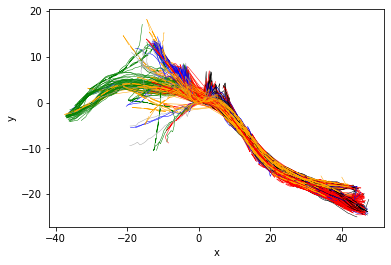

In [29]:
colors = ['red','blue','orange','black','green','darkgray']
for i in range(len(DATA05)):
    x = DATA05[i][:500]
    y = DATA05[i][500:]
    c = colors[int(labels[i])]
    plt.plot(x,y,linewidth=0.5,color = c)
    plt.xlabel('x')
    plt.ylabel('y')
    
plt.show()